# Maths4DS 101
# Lab 4. Regression and Prediction II

### Describe objectives of the lab

### Please refer to the reference book, chapter 4

[Book Chapter 4](https://learning.oreilly.com/library/view/practical-statistics-for/9781492072935/ch04.html)

### for Q&A please refer to the tags #maths4ds101 and #lab4 on stackoverflow

    
[StackOverflow](https://stackoverflow.com/c/cyberblue/questions/tagged/11)

# 0. Let's Import required Python packages.

In [6]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage


import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

In [7]:
%matplotlib inline

In [8]:
DATA='../data/'

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [9]:

HOUSE_CSV = DATA + 'house_sales.csv'

# 1. Multiple linear regression
## 1.1 The Regression Equation

An example of using multiple linear regression is in estimating the value of houses. County assessors must estimate the value of a house for the purposes of assessing taxes. Real estate professionals and home buyers consult popular websites such as Zillow to ascertain a fair price. Here are a few rows of housing data from King County (Seattle), Washington, from the house dataframe:



In [10]:
house = pd.read_csv(HOUSE_CSV, sep=',')
house.head()

,Unnamed: 0,DocumentDate,SalePrice,PropertyID,PropertyType,ym,zhvi_px,zhvi_idx,AdjSalePrice,NbrLivingUnits,...,Bedrooms,BldgGrade,YrBuilt,YrRenovated,TrafficNoise,LandVal,ImpsVal,ZipCode,NewConstruction,ZipGroup
0,1,2014-09-16,280000,1000102,Multiplex,2014-09-01,405100,0.930836,300805.0,2,...,6,7,1991,0,0,70000,229000,98002,False,2
1,2,2006-06-16,1000000,1200013,Single Family,2006-06-01,404400,0.929228,1076162.0,1,...,4,10,2005,0,0,203000,590000,98166,True,2
2,3,2007-01-29,745000,1200019,Single Family,2007-01-01,425600,0.977941,761805.0,1,...,4,8,1947,0,0,183000,275000,98166,False,2
3,4,2008-02-25,425000,2800016,Single Family,2008-02-01,418400,0.961397,442065.0,1,...,5,7,1966,0,0,104000,229000,98168,False,2
4,5,2013-03-29,240000,2800024,Single Family,2013-03-01,351600,0.807904,297065.0,1,...,4,7,1948,0,0,104000,205000,98168,False,2


The goal is to predict the sales price from the other variables

We can use the `OLS` model from statsmodel package

In [11]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms' ]
outcome = 'AdjSalePrice'


house_basic = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = house_basic.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     5690.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        06:33:04   Log-Likelihood:            -3.1611e+05
No. Observations:               22687   AIC:                         6.322e+05
Df Residuals:                   22682   BIC:                         6.323e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   327.8253      3.329     98.476

So the OLS regression line is

$$
{AdjSalePrice}=9.696e04 +327.82*SqFtTotLiving-0.0847*SqFtLot+1.326e+04*Bathrooms-7.171e04*Bedrooms
$$


The interpretation of the coefficients is as with simple linear regression: the predicted value Yˆ changes by the coefficient bj for each unit change in Xj assuming all the other variables, Xk for k≠j, remain the same. For example, adding an extra finished square foot to a house increases the estimated value by roughly 327 dollars; adding 1,000 finished square feet implies the value will increase by 327825 dollars.

Along with the estimated coefficients, R and statsmodels report the standard error of the coefficients (SE) and a t-statistic. The t-statistic—and its mirror image, the p-value—measures the extent to which a coefficient is “statistically significant”—that is, outside the range of what a random chance arrangement of predictor and target variable might produce. The higher the t-statistic (and the lower the p-value), the more significant the predictor.

We also observe that all variables are statistically significant except SqFtLot (p-value: 0.184). We also observe that the confidence interval for sqFtLot crosses the zero line [-0.210,0.040]

## 1.2 Model Selection 

In some problems, many variables could be used as predictors in a regression. For example, to predict house value, additional variables such as the basement size or year built could be used. 

In [12]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'SqFtFinBasement', 'YrBuilt']

house_full = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = house_full.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     4274.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        06:33:04   Log-Likelihood:            -3.1541e+05
No. Observations:               22687   AIC:                         6.308e+05
Df Residuals:                   22680   BIC:                         6.309e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
SqFtTotLiving     330.9591      3.367     

Adding more variables, however, does not necessarily mean we have a better model. Statisticians use the principle of Occam’s razor to guide the choice of a model: all things being equal, a simpler model should be used in preference to a more complicated model.

Including additional variables always reduces RMSE and increases R2 for the training data. Hence, these are not appropriate to help guide the model choice. One approach to including model complexity is to use the adjusted R2. Another alternative is to use a metric called AIC (Akaike’s Information Criteria) that penalizes adding terms to a model. The goal is therefore to find the model that minimizes AIC 

Based on the AIC values for the previous two models: house_basic (AIC=6.322e+05) and house_full (AIC=6.308e+05) we conclude that the latter is a better model

## 1.4 Categorical Variables

categorical variables, take on a limited number of discrete values. For example, a loan purpose can be “debt consolidation,” “wedding,” “car,” and so on. The binary (yes/no) variable, also called an indicator variable, is a special case of a categorical variable. Regression requires numerical inputs, so categorical variables need to be recoded to use in the model. The most common approach is to convert a variable into a set of binary dummy variables.

In [13]:
house.PropertyType.head()

0        Multiplex
1    Single Family
2    Single Family
3    Single Family
4    Single Family
Name: PropertyType, dtype: object

In [14]:
pd.get_dummies(house['PropertyType']).head(6)

,Multiplex,Single Family,Townhouse
0,1,0,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
5,0,0,1


When fitting dummy variables remember to drop one of them to avoid multicolinearity

In [15]:
pd.get_dummies(house['PropertyType'], drop_first=True).head(6)

,Single Family,Townhouse
0,0,0
1,1,0
2,1,0
3,1,0
4,1,0
5,0,1


In [16]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'SqFtFinBasement', 'YrBuilt','PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)


house_full_categorical = sm.OLS(house[outcome], X.assign(const=1))
results = house_full_categorical.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     3294.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        06:33:05   Log-Likelihood:            -3.1525e+05
No. Observations:               22687   AIC:                         6.305e+05
Df Residuals:                   22678   BIC:                         6.306e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

The coefficients are interpreted as relative to Multiplex, so a home that is Single Family is worth almost 93,2000 dollars more than a Multiplex home

Similarly a home that is Townhouse is worth over 226,700 dollars more than a Multiplex home

## 1.6 Ordered Factor Variables

Some factor variables reflect levels of a factor; these are termed ordered factor variables or ordered categorical variables. For example, the loan grade could be A, B, C, and so on—each grade carries more risk than the prior grade. Often, ordered factor variables can be converted to numerical values and used as is. For example, the variable BldgGrade is an ordered factor variable. While the grades have specific meaning, the numeric value is ordered from low to high, corresponding to higher-grade homes

In [17]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'SqFtFinBasement', 'YrBuilt','PropertyType','BldgGrade']

X = pd.get_dummies(house[predictors], drop_first=True)


house_full_categorical_ordinal = sm.OLS(house[outcome], X.assign(const=1))
results = house_full_categorical_ordinal.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     3695.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        06:33:05   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22677   BIC:                         6.276e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

Therefore one level increase of BldgGrade leads to 1372000 dollars increase in the outcome variable AdjSalePrice

# 2. Improving the model


## 2.1 Removing variables

In multiple regression, the predictor variables are often correlated with each other. In the previous model the coefficient for Bedrooms is negative! This implies that adding a bedroom to a house will reduce its value. How can this be? This is because the predictor variables are correlated: larger houses tend to have more bedrooms, and it is the size that drives house value, not the number of bedrooms. Consider two homes of the exact same size: it is reasonable to expect that a home with more but smaller bedrooms would be considered less desirable.

Having correlated predictors can make it difficult to interpret the sign and value of regression coefficients (and can inflate the standard error of the estimates). The variables for bedrooms, house size, and number of bathrooms are all correlated

In [18]:
house[['Bedrooms','Bathrooms','SqFtTotLiving']].corr()

,Bedrooms,Bathrooms,SqFtTotLiving
Bedrooms,1.000000,0.537998,0.600317
Bathrooms,0.537998,1.000000,0.764155
SqFtTotLiving,0.600317,0.764155,1.000000


By removing variables Bathtrooms and Bedroom we get the following model. 

In [19]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'SqFtFinBasement', 'YrBuilt','PropertyType','BldgGrade']

X = pd.get_dummies(house[predictors], drop_first=True)


house_full_categorical_ordinal = sm.OLS(house[outcome], X.assign(const=1))
results = house_full_categorical_ordinal.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     3695.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        06:33:05   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22677   BIC:                         6.276e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

## 2.2 Adding variables

Sometimes an important variable is not included in the regression equation. Naive interpretation of the equation coefficients can lead to invalid conclusions.

In our case our previous regression models did not contain a variable to represent location, a very important predictor of house price. 

To model location we can include a variable ZipGroup that categorizes the zip code into one of five groups, from least expensive (1) to most expensive (5).

In [20]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'SqFtFinBasement', 'YrBuilt','PropertyType','BldgGrade','ZipGroup']

X = pd.get_dummies(house[predictors], drop_first=True)


house_full_categorical_ordinal = sm.OLS(house[outcome], X.assign(const=1))
results = house_full_categorical_ordinal.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     4007.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        06:33:06   Log-Likelihood:            -3.1245e+05
No. Observations:               22687   AIC:                         6.249e+05
Df Residuals:                   22676   BIC:                         6.250e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

We observe a significant improvement in the model (measured by AIC: from 6.275e+05 to 6.249e+05)

We can also consider adding TrafficNoise as a relevant factor, refer to the following model

In [21]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'SqFtFinBasement', 'YrBuilt','PropertyType','BldgGrade','LandVal','ZipGroup','TrafficNoise']

X = pd.get_dummies(house[predictors], drop_first=True)


house_full_categorical_ordinal = sm.OLS(house[outcome], X.assign(const=1))
results = house_full_categorical_ordinal.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     8107.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        06:33:07   Log-Likelihood:            -3.0510e+05
No. Observations:               22687   AIC:                         6.102e+05
Df Residuals:                   22674   BIC:                         6.103e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

## 2.3 Interactions

Statisticians like to distinguish between main effects, or independent variables, and the interactions between the main effects. Main effects are what are often referred to as the predictor variables in the regression equation. An implicit assumption when only main effects are used in a model is that the relationship between a predictor variable and the response is independent of the other predictor variables. This is often not the case.

For example, the model fit to the King County Housing Data in “Confounding Variables” includes several variables as main effects, including ZipCode. Location in real estate is everything, and it is natural to presume that the relationship between, say, house size and the sale price depends on location. A big house built in a low-rent district is not going to retain the same value as a big house built in an expensive area. You include interactions between variables in Python using the * operator. For the King County data, the following fits an interaction between SqFtTotLiving and ZipGroup:

In [22]:
model = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving*ZipGroup + SqFtLot + Bathrooms + Bedrooms + BldgGrade + PropertyType+SqFtTotLiving', data=house)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     5097.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        06:33:07   Log-Likelihood:            -3.1144e+05
No. Observations:               22687   AIC:                         6.229e+05
Df Residuals:                   22677   BIC:                         6.230e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                     -4.504e+05      2e+04    -22.543      0.000    -4.9e+05   -4.11e+05
PropertyType[T.Single Family]  7151.4567   1.42e+04      0.504      0.614   -2.07e+04     3.5e+04
PropertyType[T.Townhouse]     -6.785e+04   1.54e+04     -4.395      0.000   -9.81e+04   -3.76e+04
SqFtTotLiving                    82.0903      4.321     18.997      0.000      73.621      90.560
ZipGroup                      -4.009e+04   2615.492    -15.329      0.000   -4.52e+04    -3.5e+04
SqFtTotLiving:ZipGroup           56.5726      1.117     50.625      0.000      54.382      58.763
SqFtLot                           0.5696      0.052     10.858      0.000       0.467       0.672
Bathrooms                     -4969.7195   3260.266     -1.524      0.127   -1.14e+04    1420.625
Bedrooms                      -4.457e+04   2159.392    -20.638      0.000   -4.88e+04   -4.03e+04
BldgGrade                      1.092e+05   2093.900     52.157      0.000    1.05e+05    1.13e+05
==============================================================================
Omnibus:                    30996.953   Durbin-Watson:                   1.558
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         32932527.973
Skew:                           7.331   Prob(JB):                         0.00
Kurtosis:                     189.074   Cond. No.                     5.55e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.55e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Location and house size appear to have a strong interaction. For a home in the lowest ZipGroup, the slope is the same as the slope for the main effect SqFtTotLiving, which is 82 dollars per square foot. For a home in the highest ZipGroup, the slope is the sum of the main effect (SqFtToLiving) plus SqFtTotLiving:ZipGroup5, or 82 + (56.57*5) = 364.85 dollars per square foot. In other words, adding a square foot in the most expensive zip code group boosts the predicted sale price by a factor of almost five, compared to the average boost from adding a square foot.

## 2.4 Quadratic terms

The relationship between the response and a predictor variable isn’t necessarily linear. For example, the following fits a quadratic term for SqFtTotLiving with the King County housing data:

In statsmodels, we add the squared term to the model definition using I(SqFtTotLiving**2):

In [23]:
model_poly = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving + I(SqFtTotLiving**2) + SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house)
result_poly = model_poly.fit()
result_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AdjSalePrice   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     5743.
Date:                Fri, 09 Apr 2021   Prob (F-statistic):               0.00
Time:                        06:33:07   Log-Likelihood:            -3.1351e+05
No. Observations:               22687   AIC:                         6.270e+05
Df Residuals:                   22680   BIC:                         6.271e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              -2.93e+05    1.5e+04    -19.473      0.000   -3.22e+05   -2.63e+05
SqFtTotLiving          -136.8723      7.113    -19.243      0.000    -150.814    -122.931
I(SqFtTotLiving ** 2)     0.0600      0.001     59.752      0.000       0.058       0.062
SqFtLot                  -0.2371      0.057     -4.163      0.000      -0.349      -0.125
Bathrooms             -2687.6768   3381.556     -0.795      0.427   -9315.758    3940.404
Bedrooms              -1.751e+04   2369.046     -7.391      0.000   -2.22e+04   -1.29e+04
BldgGrade              1.173e+05   2235.437     52.475      0.000    1.13e+05    1.22e+05
==============================================================================
Omnibus:                    24370.253   Durbin-Watson:                   1.262
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9294565.125
Skew:                           4.846   Prob(JB):                         0.00
Kurtosis:                     101.684   Cond. No.                     6.94e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.94e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 3. Regression Diagnostics

## 3.1. HeteroSkedasticity

Statisticians pay considerable attention to the distribution of the residuals.

The distribution of the residuals is relevant mainly for the validity of formal statistical inference (hypothesis tests and p-values). Normally distributed errors are a sign that the model is complete; errors that are not normally distributed indicate the model may be missing something. For formal inference to be fully valid, the residuals are assumed to be normally distributed, have the same variance, and be independent.

Heteroskedasticity is the lack of constant residual variance across the range of the predicted values. In other words, errors are greater for some portions of the range than for others. Visualizing the data is a convenient way to analyze residuals.

In [24]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

model = sm.OLS(house[outcome],house[predictors].assign(const=1))
result = model.fit()

/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'abs(residual)')

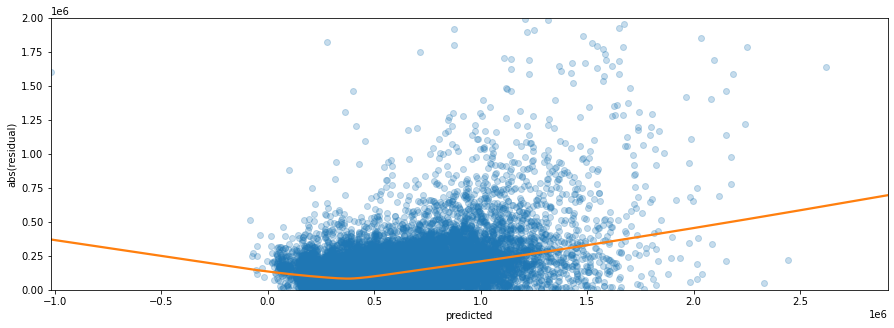

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.regplot(result.fittedvalues, np.abs(result.resid),
            scatter_kws={'alpha': 0.25}, line_kws={'color': 'C1'},
            lowess=True, ax=ax)

ax.set(ylim=(0, 2000000)) 
ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')

Evidently, the variance of the residuals tends to increase for higher-valued homes but is also large for lower-valued homes. This plot indicates that the model has heteroskedastic errors and that we have left something unaccounted for in high- and low-range homes.

In [26]:
model = smf.ols(formula='AdjSalePrice ~  SqFtTotLiving*ZipGroup + SqFtLot + Bathrooms + Bedrooms + BldgGrade + PropertyType+SqFtTotLiving+ I(SqFtTotLiving**2)', data=house)
results = model.fit()


/srv/conda/envs/notebook/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'abs(residual)')

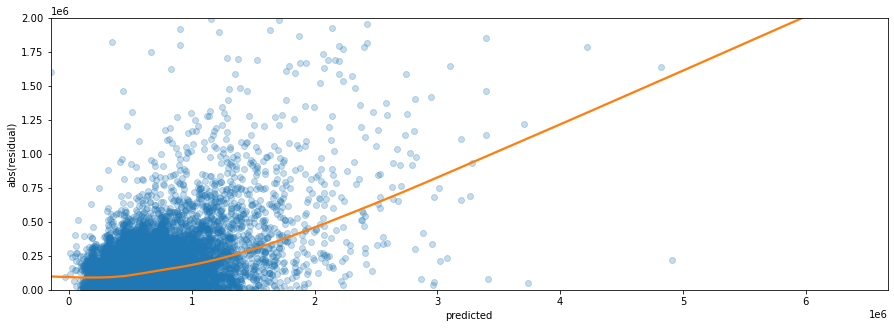

In [27]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.regplot(results.fittedvalues, np.abs(result.resid),
            scatter_kws={'alpha': 0.25}, line_kws={'color': 'C1'},
            lowess=True, ax=ax)

ax.set(ylim=(0, 2000000)) 
ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')

We have fixed the problem for low-value ranges, there is still work to do for high-value ranges however.

In the next lab we will develop advanced models to achieve better fit in presence of non-linear effects.